# <b> Natural Language Processing - Sarcasm

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import *
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import sent_tokenize, word_tokenize
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
stop_words = stopwords.words('english')
import string
import nltk 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(stop_words='english')

from keras.backend.tensorflow_backend import set_session
#set tensorflow to grow memory usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # d
config.log_device_placement = True 
sess = tf.Session(config = config)
set_session(sess)

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### <b> Loading a json file

In [2]:
with open("../data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
sentences[0:2]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]

In [5]:
labels[0:10]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

### <b> Clean Text

In [6]:
'''
Function for remove symbols ans stopwords 
'''
def _cleasing_(text):
    words = word_tokenize(text) 
    text = [w.lower() for w in words if w not in string.punctuation and w.isalpha()]
    text = [w for w in text if w not in stop_words]
    return ' '.join(text)

In [7]:
sentences = [_cleasing_(line) for line in sentences]

### <b> Exploratory Data Analysis

#### <b> Words Frequency

In [8]:
'''
Compute the frequency distibution of words from corpus 
'''
def words_frequency(tokens):
    # frequency of tokens
    text = nltk.FreqDist(tokens)
    
    # organize data in dataframe
    words_df = pd.DataFrame()
    words_df['words'] = text.keys()
    words_df['freq'] = text.values()
    
    # Normalize
    words_df['norm'] = [x/unique_words_quantity for x in words_df['freq']]
    return words_df.sort_values(by = 'freq', ascending=False)

#join all lines in a consice text
full_text = ''.join(sentences)

# words as individual tokens
tokens = word_tokenize(full_text)

# corpus unique words
unique_words_quantity = len(set(tokens))

# words frequency in a dataframe
df_frequency = words_frequency(tokens)
df_frequency.head()

,words,freq,norm
54,trump,1087,0.023645
321,new,988,0.021491
59,man,734,0.015966
470,says,372,0.008092
495,one,361,0.007853


In [9]:
print(unique_words_quantity)

45972


#### <b> Word Cloud

In [10]:
def word_cloud(tokens):
    from wordcloud import WordCloud
    frequency = nltk.FreqDist(tokens)
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequency)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

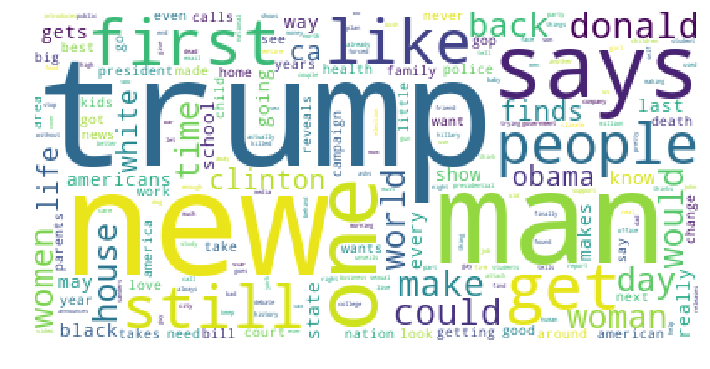

In [11]:
word_cloud(tokens)

### <b>  TDIDF

In [12]:
'''
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
'''
def _tf_idf_(docs):
    # this steps generates word counts for the words in your docs
    word_count_vector=cv.fit_transform(docs)
    
    # weights based on count
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    # organize data in dataframe
    df = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["TFIDF"])
    df =  df.sort_values(by=['TFIDF'], ascending=False)

    return df

tf_idf = _tf_idf_(tokens)

tf_idf.head(10)

,TFIDF
lifetimebush,12.228418
pantsmerkel,12.228418
pantherseagles,12.228418
pantiesreflecting,12.228418
pantsawkward,12.228418
pantsgroundbreaking,12.228418
pantshilary,12.228418
pantskey,12.228418
pantsmadeleine,12.228418
pantspaul,12.228418


Too many misspelled words lead to weighted words

### <b> POS Tag

In [13]:
from nltk import RegexpParser

In [14]:
# process the tagging
pos_words = nltk.pos_tag(tokens)
print(pos_words[0:10])

[('former', 'JJ'), ('versace', 'NN'), ('store', 'NN'), ('clerk', 'NN'), ('sues', 'VBZ'), ('secret', 'JJ'), ('code', 'NN'), ('minority', 'NN'), ('shoppersrevival', 'NN'), ('catches', 'NNS')]


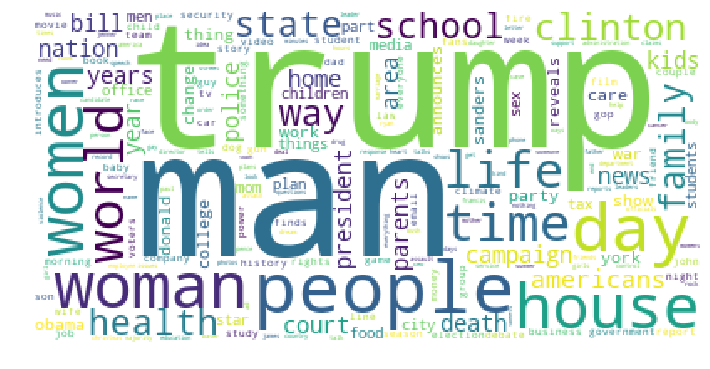

In [15]:
# filter by Nouns
nn_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('NN')]
list_nn  = [nn[0] for nn in nn_tagged]
word_cloud(list_nn)

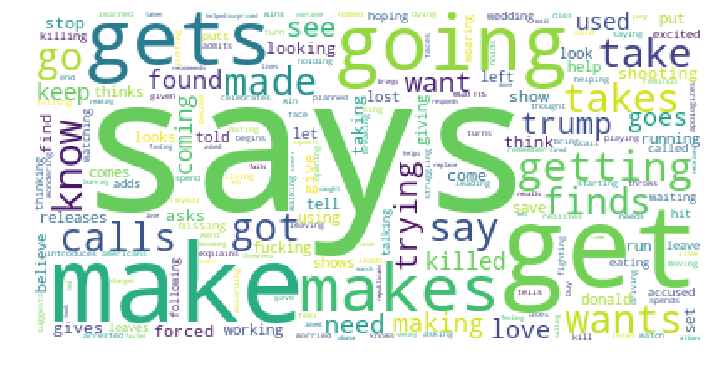

In [16]:
# filter by Verbs
vb_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('VB')]
list_vb  = [vb[0] for vb in vb_tagged]
word_cloud(list_vb)

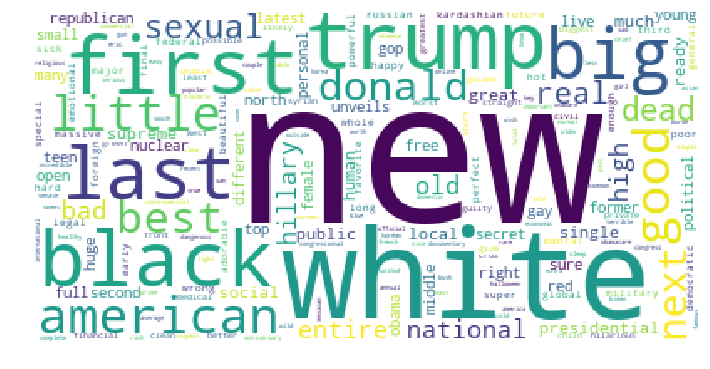

In [17]:
# filter by Adjectives
jj_tagged = [(word,tag) for word, tag in pos_words
                if tag.startswith('JJ')]
list_jj  = [jj[0] for jj in jj_tagged]
word_cloud(list_jj)

In [18]:
len(nn_tagged), len(vb_tagged), len(jj_tagged)

(74246, 33691, 31081)

### <b> Configuring parameters

In [19]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
padding_type='post'
oov_tok = "<OOV>"

In [20]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentences, labels, test_size = 0.1, random_state = 42)

In [21]:
len(sentence_train), len(label_train), len(sentence_test), len(label_test)

(24038, 24038, 2671, 2671)

### <b> Encoding

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# build vocabulary
tokenizer.fit_on_texts(sentence_train)
vocabulary = tokenizer.word_index

In [28]:
# Features
train_sequences = tokenizer.texts_to_sequences(sentence_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

#Target
test_sequences = tokenizer.texts_to_sequences(sentence_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [29]:
print("Original sentence = ", sentence_train[0])
print("Tokenized sentence = ", train_sequences[0])
print("Padded sentence = ", train_padded_sequences[0])

Original sentence =  win mall america dream shooting spree
Tokenized sentence =  [284, 1, 38, 397, 162, 1]
Padded sentence =  [284   1  38 397 162   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [30]:
print(labels[0:10])

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


In [31]:
len(train_padded_sequences), len(label_train), len(test_padded_sequences), len(label_test), 

(24038, 24038, 2671, 2671)

### <b> Bidirectional LSTM

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,  input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 32,769
Trainable params: 32,769
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
num_epochs = 50
history = model.fit(train_padded_sequences, label_train, 
                    epochs=num_epochs, validation_data=(test_padded_sequences, label_test), verbose=1)

Train on 24038 samples, validate on 2671 samples
Epoch 1/50
24038/24038 [==============================] - 110s 5ms/sample - loss: 0.5441 - acc: 0.7078 - val_loss: 0.5087 - val_acc: 0.7514
Epoch 2/50
24038/24038 [==============================] - 117s 5ms/sample - loss: 0.4624 - acc: 0.7703 - val_loss: 0.4855 - val_acc: 0.7529
Epoch 3/50
24038/24038 [==============================] - 113s 5ms/sample - loss: 0.4417 - acc: 0.7831 - val_loss: 0.4854 - val_acc: 0.7507
Epoch 4/50
24038/24038 [==============================] - 116s 5ms/sample - loss: 0.4331 - acc: 0.7860 - val_loss: 0.4872 - val_acc: 0.7522
Epoch 5/50
10208/24038 [===========>..................] - ETA: 1:03 - loss: 0.4153 - acc: 0.7998